In [37]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.fft import rfft, rfftfreq, irfft
from scipy.signal import argrelextrema

In [38]:
#fits_image_filename = '/home/donlon/Desktop/rrlyrae_light_curve_q1.fits'
#fits_image_filename = '/home/donlon/Desktop/rrlyrae_light_curve_sc2.fits'
fits_image_filename = '/home/donlon/Desktop/nrlyrae_light_curve_q2.fits'
light_curve = fits.open(fits_image_filename)

In [39]:
print(light_curve.info())

Filename: /home/donlon/Desktop/nrlyrae_light_curve_q2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   4354R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (7, 7)   int32   
None


In [40]:
header = light_curve[0].header
print(repr(header))

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2015-09-07'         / file creation date.                            
CREATOR = '823889 FluxExporter2PipelineModule' / pipeline job and program used t
PROCVER = 'svn+ssh://murzim/repo/soc/tags/release/9.3.22 r60269' / SW version   
FILEVER = '6.1     '           / file format version                            
TIMVERSN= 'OGIP/93-003'     

In [41]:
print(light_curve[1].columns)

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2454833'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E13.6'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; uni

In [42]:
# Read in the "BJDREF" which is the time offset of the time array.
bjdrefi = light_curve[1].header['BJDREFI'] 
bjdreff = light_curve[1].header['BJDREFF']

# Read in the columns of data.
times = light_curve[1].data['time'] 
sap_fluxes = light_curve[1].data['SAP_FLUX']
pdcsap_fluxes = light_curve[1].data['PDCSAP_FLUX']
    
bjds = times + bjdrefi + bjdreff 

sample_spacing = (bjds[-1] - bjds[0])/len(bjds)
print('sample length', bjds[-1] - bjds[0], 'days')
print('sample spacing:', sample_spacing, 'BJDs')
sample_rate = 1/sample_spacing
print('sample rate:', sample_rate, 'BJDs^-1')
print('number of samples:', len(bjds))

sample length 88.94677847344428 days
sample spacing: 0.02042875022357471 BJDs
sample rate: 48.9506205252832 BJDs^-1
number of samples: 4354


In [43]:
period = 0.68202

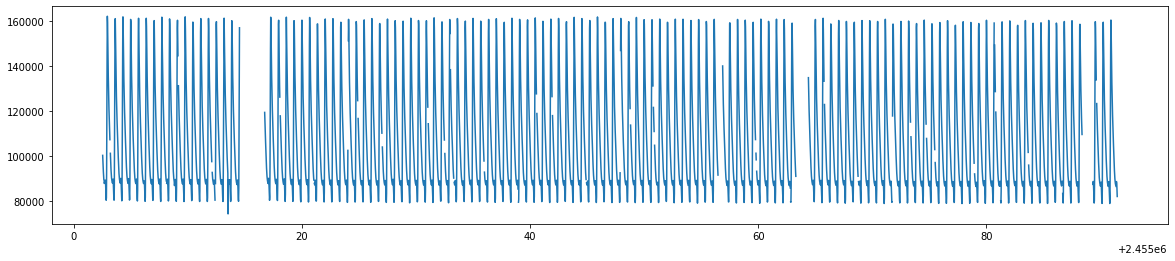

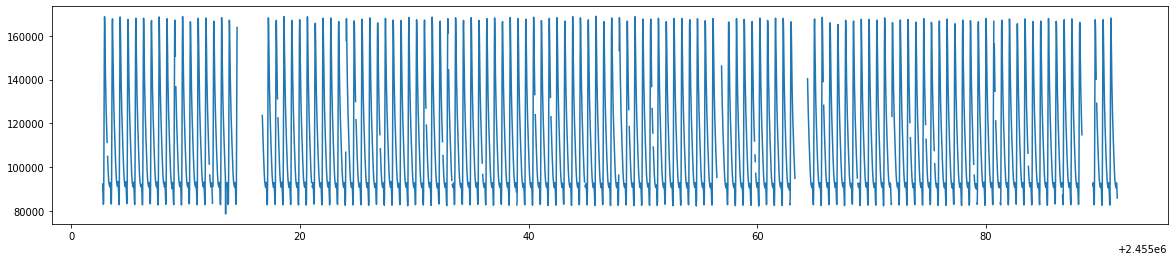

In [44]:
fig = plt.figure(figsize=(20, 4))
plt.plot(bjds, sap_fluxes)
plt.show()

fig = plt.figure(figsize=(20, 4))
plt.plot(bjds, pdcsap_fluxes)
plt.show()

In [45]:
interp_sap_fluxes = [(sap_fluxes[i] if not(np.isnan(sap_fluxes[i])) else (sap_fluxes[i-1] + sap_fluxes[i+1])/2 ) for i in range(len(sap_fluxes))]
                      

In [46]:
for j in range(100):
    interp_sap_fluxes = [(interp_sap_fluxes[i] if not(np.isnan(interp_sap_fluxes[i])) else (interp_sap_fluxes[i-j] + interp_sap_fluxes[i+j])/2 ) for i in range(len(sap_fluxes))]
                      

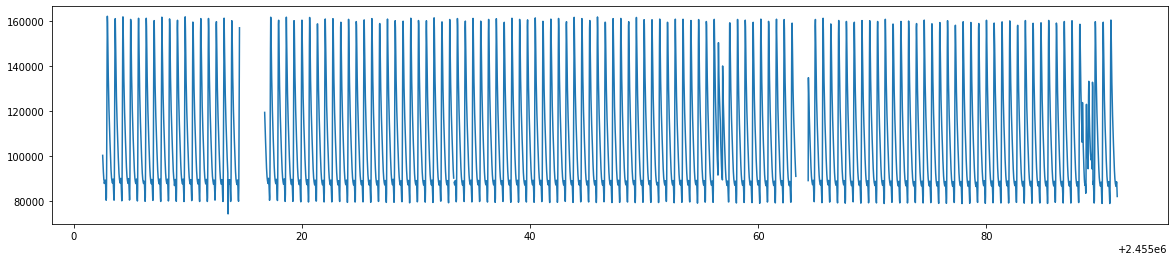

In [47]:
fig = plt.figure(figsize=(20, 4))
plt.plot(bjds, interp_sap_fluxes)
plt.show()

422


/tmp/ipykernel_20498/2567510427.py:1: RuntimeWarning: invalid value encountered in remainder
  folded_bjds = (bjds % period)/period


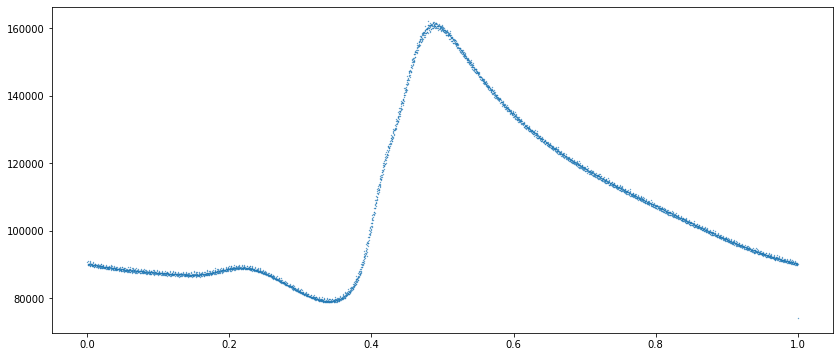

In [48]:
folded_bjds = (bjds % period)/period

fig = plt.figure(figsize=(14, 6))
plt.scatter(folded_bjds, sap_fluxes, s=0.1)
#plt.xlim(0.2, 0.3)
print(len(folded_bjds[(folded_bjds > 0.2)*(folded_bjds < 0.3)]))
plt.show()

In [49]:
#plot o-c diagram

period = 0.68202

loop_num = bjds // period
loop_num -= np.nanmin(loop_num)
print(loop_num)

#build "model"
indx = (loop_num == 0)
c_max_light_indx = np.argmax(pdcsap_fluxes[indx])

o_c = [0]

for i in range(int(np.nanmax(loop_num))):
    indx = (loop_num == i)
    
    try:
        o_max_light_indx = np.argmax(pdcsap_fluxes[indx])
        o_c.append((c_max_light_indx - o_max_light_indx)*sample_spacing)
    except ValueError: #avoids gaps in the data crashing the routine
        o_c.append(np.nan)
    

[  0.   0.   0. ... 131. 131. 131.]


/tmp/ipykernel_20498/909353394.py:5: RuntimeWarning: invalid value encountered in floor_divide
  loop_num = bjds // period


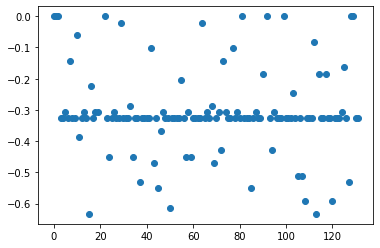

In [50]:
plt.scatter(np.arange(0, len(o_c)), o_c)
plt.show()

In [51]:
fits_image_filename = '/home/donlon/Desktop/nrlyrae_light_curve_q16.fits'
light_curve2 = fits.open(fits_image_filename)

In [52]:
# Read in the "BJDREF" which is the time offset of the time array.
bjdrefi = light_curve2[1].header['BJDREFI'] 
bjdreff = light_curve2[1].header['BJDREFF']

# Read in the columns of data.
times2 = light_curve2[1].data['time'] 
sap_fluxes2 = light_curve2[1].data['SAP_FLUX']
pdcsap_fluxes2 = light_curve2[1].data['PDCSAP_FLUX']
    
bjds2 = times2 + bjdrefi + bjdreff 

sample_spacing2 = (bjds[-1] - bjds[0])/len(bjds)
print('sample length', bjds2[-1] - bjds2[0], 'days')
print('sample spacing:', sample_spacing2, 'BJDs')
sample_rate2 = 1/sample_spacing2
print('sample rate:', sample_rate2, 'BJDs^-1')
print('number of samples:', len(bjds2))

sample length 85.86279879976064 days
sample spacing: 0.02042875022357471 BJDs
sample rate: 48.9506205252832 BJDs^-1
number of samples: 4203


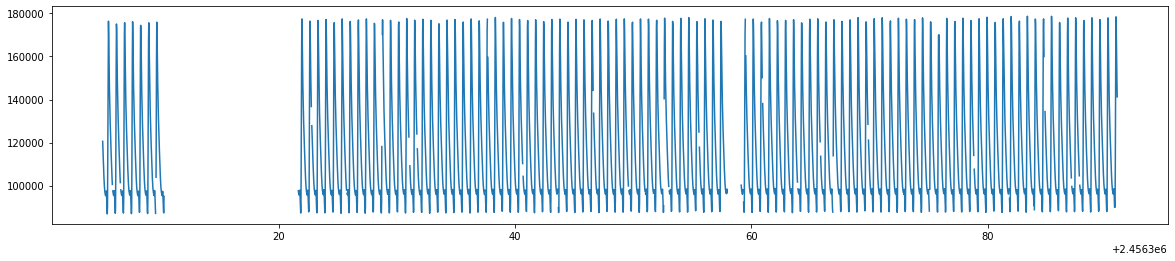

In [53]:
fig = plt.figure(figsize=(20, 4))
plt.plot(bjds2, sap_fluxes2)
plt.show()

In [54]:
interp_sap_fluxes2 = [(sap_fluxes2[i] if not(np.isnan(sap_fluxes2[i])) else (sap_fluxes2[i-1] + sap_fluxes2[i+1])/2 ) for i in range(len(sap_fluxes2))]
                      
for j in range(100):
    interp_sap_fluxes2 = [(interp_sap_fluxes2[i] if not(np.isnan(interp_sap_fluxes2[i])) else (interp_sap_fluxes2[i-j] + interp_sap_fluxes2[i+j])/2) for i in range(len(sap_fluxes2))]
                      

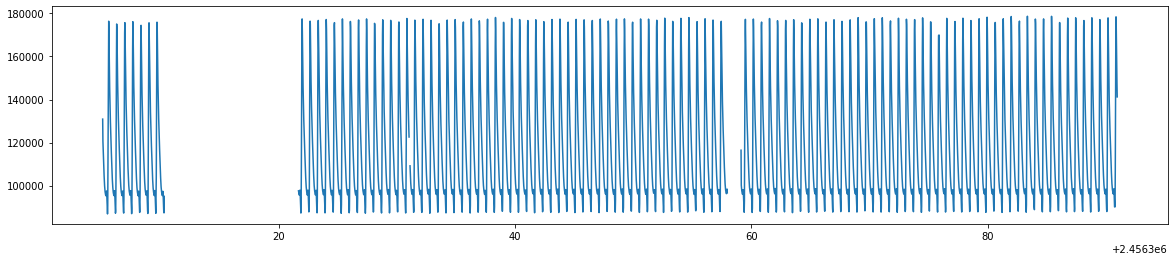

In [55]:
fig = plt.figure(figsize=(20, 4))
plt.plot(bjds2, interp_sap_fluxes2)
plt.show()

In [56]:
period_shift = ((bjds2[0] - bjds[0])/0.68202)%1
print('shift in periods due to offset in start times:', period_shift, 'periods')

shift in periods due to offset in start times: 0.879007532565538 periods


In [57]:
fits_image_filename = '/home/donlon/Desktop/nrlyrae_light_curve_q9.fits'
light_curve3 = fits.open(fits_image_filename)

In [58]:
# Read in the "BJDREF" which is the time offset of the time array.
bjdrefi = light_curve3[1].header['BJDREFI'] 
bjdreff = light_curve3[1].header['BJDREFF']

# Read in the columns of data.
times3 = light_curve3[1].data['time'] 
sap_fluxes3 = light_curve3[1].data['SAP_FLUX']
pdcsap_fluxes3 = light_curve3[1].data['PDCSAP_FLUX']
    
bjds3 = times3 + bjdrefi + bjdreff 

sample_spacing3 = (bjds[-1] - bjds[0])/len(bjds)
print('sample length', bjds3[-1] - bjds3[0], 'days')
print('sample spacing:', sample_spacing3, 'BJDs')
sample_rate3 = 1/sample_spacing3
print('sample rate:', sample_rate3, 'BJDs^-1')
print('number of samples:', len(bjds3))

sample length 97.41115603363141 days
sample spacing: 0.02042875022357471 BJDs
sample rate: 48.9506205252832 BJDs^-1
number of samples: 4768


/tmp/ipykernel_20498/3213688903.py:2: RuntimeWarning: invalid value encountered in remainder
  folded_bjds = (bjds % period)/period
/tmp/ipykernel_20498/3213688903.py:3: RuntimeWarning: invalid value encountered in remainder
  folded_bjds2 = (bjds2 % period)/period
/tmp/ipykernel_20498/3213688903.py:4: RuntimeWarning: invalid value encountered in remainder
  folded_bjds3 = (bjds3 % period)/period


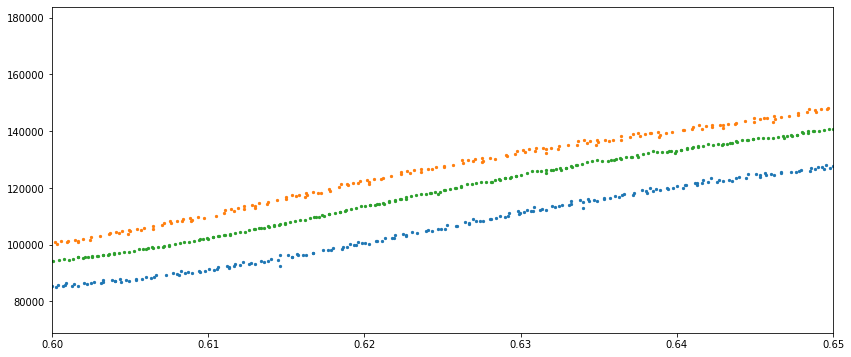

In [59]:
period = 0.68203 #0.68202
folded_bjds = (bjds % period)/period
folded_bjds2 = (bjds2 % period)/period
folded_bjds3 = (bjds3 % period)/period

fig = plt.figure(figsize=(14, 6))
plt.scatter(folded_bjds, sap_fluxes, s=5)
plt.scatter(folded_bjds2, sap_fluxes2, s=5)
plt.scatter(folded_bjds3, pdcsap_fluxes3, s=5)
plt.xlim(0.6, 0.65)
#plt.ylim(120000, 160000)
plt.show()

/tmp/ipykernel_20498/872973764.py:2: RuntimeWarning: invalid value encountered in remainder
  folded_bjds = (bjds % period)/period
/tmp/ipykernel_20498/872973764.py:3: RuntimeWarning: invalid value encountered in remainder
  folded_bjds2 = (bjds2 % period)/period
/tmp/ipykernel_20498/872973764.py:4: RuntimeWarning: invalid value encountered in remainder
  folded_bjds3 = (bjds3 % period)/period
/tmp/ipykernel_20498/872973764.py:9: RuntimeWarning: invalid value encountered in floor_divide
  plt.scatter(folded_bjds3, pdcsap_fluxes3, s=1, c=bjds3//period)


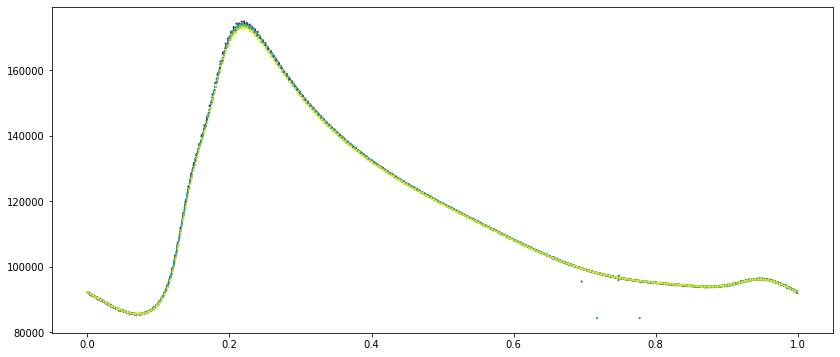

In [318]:
period = 0.682021#0.68202
folded_bjds = (bjds % period)/period
folded_bjds2 = (bjds2 % period)/period
folded_bjds3 = (bjds3 % period)/period

fig = plt.figure(figsize=(14, 6))
# plt.scatter(folded_bjds, sap_fluxes, s=0.1)
# plt.scatter(folded_bjds2, sap_fluxes2, s=0.1)
plt.scatter(folded_bjds3, pdcsap_fluxes3, s=1, c=bjds3//period)
#plt.xlim(0.675, 0.725)
#plt.ylim(122500, 135000)
plt.show()

/tmp/ipykernel_20498/4028754818.py:9: RuntimeWarning: invalid value encountered in remainder
  all_folded_bjds = (all_bjds % period)/period


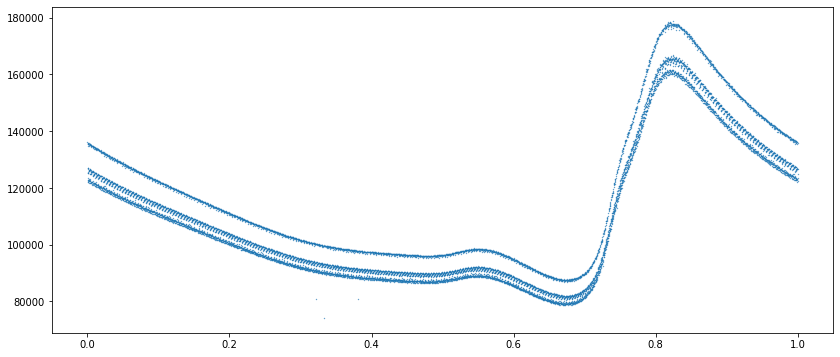

In [251]:
period = 0.682026

all_bjds = np.append(np.append(bjds, bjds3), bjds2)
all_sap_fluxes = np.append(np.append(sap_fluxes, sap_fluxes3), sap_fluxes2)

#all_bjds = np.append(bjds, bjds2)
#all_sap_fluxes = np.append(sap_fluxes, sap_fluxes2)

all_folded_bjds = (all_bjds % period)/period

fig = plt.figure(figsize=(14, 6))
plt.scatter(all_folded_bjds, all_sap_fluxes, s=0.1)
plt.show()

/tmp/ipykernel_20498/1520926082.py:8: RuntimeWarning: invalid value encountered in remainder
  all_folded_bjds = ((all_bjds - phase_shift) % 0.68202)/0.68202


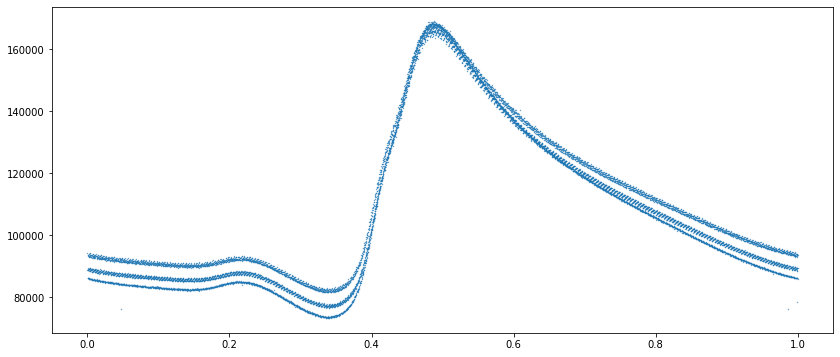

In [121]:
all_bjds = np.append(np.append(bjds, bjds3), bjds2)
all_sap_fluxes = np.append(np.append(pdcsap_fluxes, pdcsap_fluxes3), pdcsap_fluxes2)

#all_bjds = np.append(bjds, bjds2)
#all_sap_fluxes = np.append(sap_fluxes, sap_fluxes2)

phase_shift = (all_bjds - np.nanmin(all_bjds))*0.00001
all_folded_bjds = ((all_bjds - phase_shift) % 0.68202)/0.68202
flux_shift = (all_bjds - np.nanmin(all_bjds))*12

fig = plt.figure(figsize=(14, 6))
plt.scatter(all_folded_bjds, all_sap_fluxes - flux_shift, s=0.1)
plt.show()

/tmp/ipykernel_20498/1562300608.py:5: RuntimeWarning: invalid value encountered in floor_divide
  loop_num = all_bjds // period


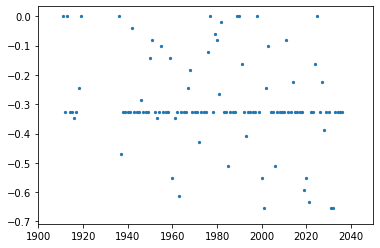

In [233]:
#plot o-c diagram

period = 0.682045#0.682054

loop_num = all_bjds // period
loop_num -= np.nanmin(loop_num)
#print(loop_num)

#build "model"
indx = (loop_num == 0)
c_max_light_indx = np.argmax(all_sap_fluxes[indx])

o_c = [0]
for i in range(int(np.nanmax(loop_num))):
    indx = (loop_num == i)
    
    try:
        o_max_light_indx = np.argmax(all_sap_fluxes[indx])
        o_c.append((c_max_light_indx - o_max_light_indx)*sample_spacing)
    except ValueError: #avoids gaps in the data crashing the routine
        o_c.append(np.nan)
        
#indx = (np.array(o_c) < -0.45)*(np.array(o_c) > -0.48)
plt.scatter(np.arange(0, len(np.array(o_c))), np.array(o_c), s=5)
plt.xlim(1900, 2050)
#print(np.std(np.array(o_c)))
plt.show()
    

In [538]:
low = np.nanmin(bjds) + 18 #bjds
high = np.nanmin(bjds) + 55
indx = (bjds > low)*(bjds < high)

#usable_fluxes = interp_sap_fluxes
usable_fluxes = np.array(interp_sap_fluxes)[indx]
usable_bjds = np.array(bjds)[indx]

tmp = usable_fluxes - np.mean(usable_fluxes)
power_series = rfft(tmp / np.max(tmp))
mag_power_series = np.abs(power_series)
power_series_bins = rfftfreq(len(usable_fluxes), sample_spacing)

In [535]:
delta_f = sample_rate / len(usable_fluxes)
print('scale of fft:', delta_f, ' inverse BJDs')

scale of fft: 0.0270445417266758  inverse BJDs


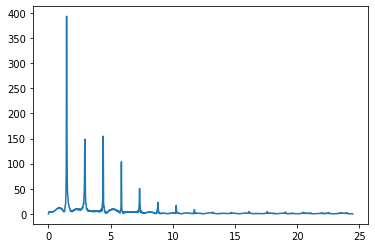

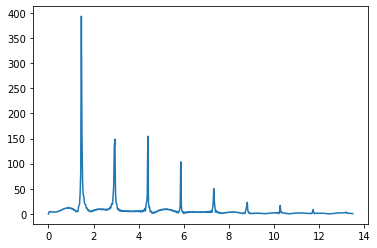

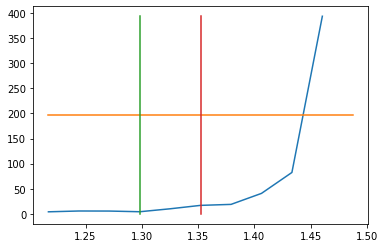

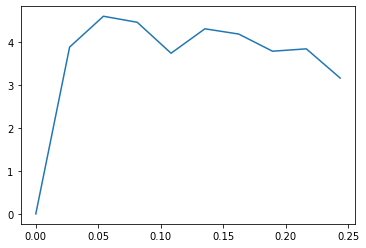

In [613]:
#mag_power_series = mag_power_series/np.max(mag_power_series)

plt.plot(power_series_bins, mag_power_series)
plt.show()

plt.plot(power_series_bins[0:500], mag_power_series[0:500])
plt.show()

low = 45
high = 55
plt.plot(power_series_bins[low:high], mag_power_series[low:high])
plt.plot([power_series_bins[low],power_series_bins[high]], [0.5*np.max(mag_power_series[low:high])]*2)
plt.plot([power_series_bins[48]]*2, [0, np.max(mag_power_series[low:high])])
plt.plot([power_series_bins[50]]*2, [0, np.max(mag_power_series[low:high])])
plt.show()

plt.plot(power_series_bins[0:10], mag_power_series[0:10])
# plt.plot([power_series_bins[55],power_series_bins[65]], [0.5*np.max(mag_power_series[55:65])]*2)
# plt.plot([power_series_bins[58]]*2, [0, np.max(mag_power_series[55:65])])
# plt.plot([power_series_bins[60]]*2, [0, np.max(mag_power_series[55:65])])
plt.show()

In [605]:
tol = 0.15

In [606]:
print('Periods of overtones: (in days)')
peak_inds = np.array(argrelextrema(mag_power_series, np.greater)[0])
peak_inds = peak_inds[mag_power_series[peak_inds] > tol*np.max(power_series)] #cut things that are probably noise
print(1/(power_series_bins[peak_inds]))

Periods of overtones: (in days)
[0.68474144 0.33922971 0.22684686 0.17039649 0.13644294 0.11342343]


In [607]:
print('Peaks of overtones:')
print((mag_power_series[peak_inds]))

Peaks of overtones:
[393.29002802 148.8800402  154.56210211 103.62462871  50.44017762
  23.01183107]


In [608]:
print('Fundamental period of star:', 1/power_series_bins[peak_inds][0], 'days')
#may need to skip the peak at 0, which can be artificial based on a nonzero mean offset or something I think

Fundamental period of star: 0.6847414426790782 days


In [609]:
print('power series resolution:', delta_f/86400, 's^-1') #conversion to inverse seconds

power series resolution: 3.130155292439329e-07 s^-1


In [671]:
#this is all overtone fitting nonsense

In [791]:
truncated_power_series = [(power_series[i] if mag_power_series[i] > 0.01*np.max(mag_power_series) else 0) for i in range(len(power_series))]

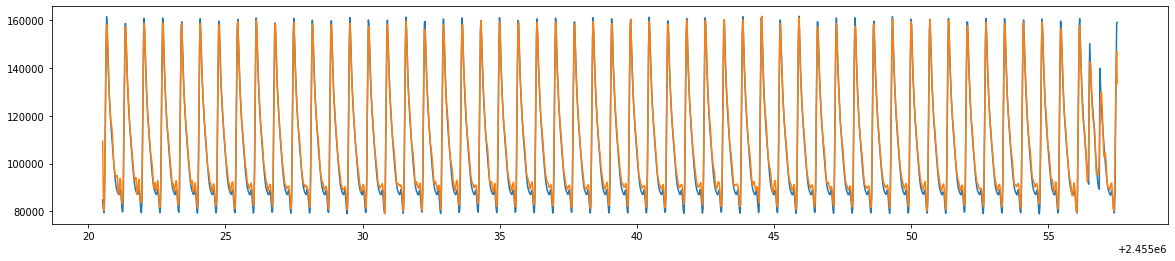

In [792]:
y = irfft(truncated_power_series)
y = ((y - np.min(y))/(np.max(y) - np.min(y)))*(np.max(usable_fluxes) - np.min(usable_fluxes)) + np.min(usable_fluxes) #scale y
fig = plt.figure(figsize=(20, 4))
plt.plot(usable_bjds, usable_fluxes)
plt.plot(usable_bjds, y)
plt.show()

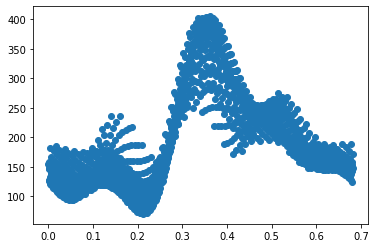

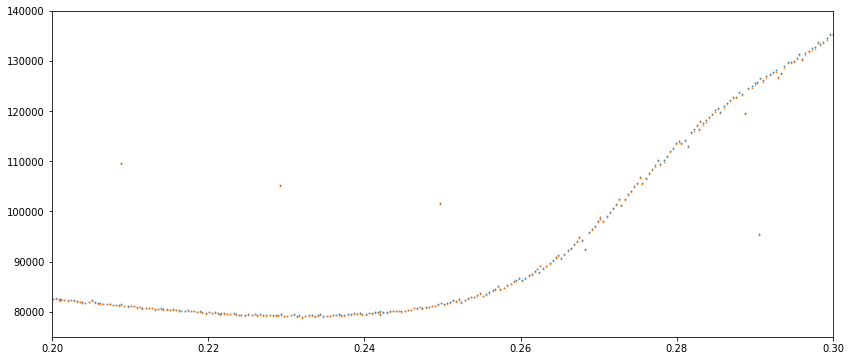

In [670]:
folded_bjds = usable_bjds % 0.68202

truncated_power_series = [(power_series[i] if mag_power_series[i] > tol*np.max(mag_power_series) else 0) for i in range(len(power_series))]
truncated_power_series_o = [(power_series[i] if mag_power_series[i] > 0.99*np.max(mag_power_series) else 0) for i in range(len(power_series))]

y = irfft(truncated_power_series)
yo = irfft(truncated_power_series_o)

truncated_power_series = [(power_series[i] if mag_power_series[i] > tol*np.max(mag_power_series) else 0) for i in range(len(power_series))]
truncated_power_series[np.array(truncated_power_series).nonzero()[0][0]] = 0

#norm_bjds = bjds - np.nanmin(bjds)
y2 = irfft(truncated_power_series)
# plt.scatter(folded_bjds, y-yo)
# plt.show()
# plt.scatter(folded_bjds, y2)
# plt.show()
# plt.scatter(folded_bjds, yo)
# plt.show()
# plt.scatter(folded_bjds, y)
# plt.show()
#tweaks = ((y - np.min(y))/(np.max(y) - np.min(y)))*(np.max(usable_fluxes) - np.min(usable_fluxes)) + np.min(usable_fluxes) #scale y
tweaks = (y2/2 + 0.5)*np.max(np.abs(truncated_power_series))
plt.scatter(folded_bjds, tweaks)
plt.show()


fig = plt.figure(figsize=(14, 6))
plt.scatter(folded_bjds, usable_fluxes, s=0.5)
plt.scatter(folded_bjds, usable_fluxes-tweaks, s=0.5)
plt.xlim(0.2, 0.3)
plt.ylim(75000, 140000)
plt.show()